In [1]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.models import Model
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import os

## Environment variables

In [16]:
RESIZE_IMAGE = 224
CHANNELS = 3

IMAGE_SHAPE = (
    RESIZE_IMAGE,
    RESIZE_IMAGE,
    CHANNELS
)

RESULT_CSV = 'flickr30k_dataset/results.csv'
DATASET_PATH_DEFAULT = 'flickr30k_dataset/flickr30k_images'
MAX_LENGTH=20

In [3]:
RESULT_CSV = 'flickr30k_dataset/results.csv'
df = pd.read_csv(
    RESULT_CSV, 
    delimiter='|',
    header=0,
    names=[
        'image_label',
        'number_comment',
        'comment'
    ]
)

df.head()

,image_label,number_comment,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [4]:
id = df['image_label'].values
print('ID IMAGES SHAPE ', id.shape)

comment = df['comment']
print('COMMENT SHAPE', comment.shape)

ID IMAGES SHAPE  (158915,)
COMMENT SHAPE (158915,)


In [5]:
def sentence_cleaning(sentence):
    try:
        sentence = sentence.lower()
        sentence = re.sub('[^a-z]+', ' ', sentence)
        sentence = sentence.split()
        sentence = [word for word in sentence if len(word) > 1]
        sentence = ' '.join(sentence)
        return(sentence)
    except:
        return(sentence_cleaning('A dog runs a cross the grass .'))

In [6]:
vocab_dict = {}

for i in range(comment.shape[0]):
    if id[i] not in vocab_dict:
        vocab_dict[id[i]] = []
    sen = sentence_cleaning(comment[i])
    vocab_dict[id[i]].append(sen)
    
len(vocab_dict)

31783

In [7]:
# print(vocab_dict[''])
LAST_IMAGE = list(vocab_dict.keys())[-1]
print(LAST_IMAGE)
print(vocab_dict[LAST_IMAGE])

998845445.jpg
['man in shorts and hawaiian shirt leans over the rail of pilot boat with fog and mountains in the background', 'young man hanging over the side of boat which is in like with fog rolling over hill behind it', 'man is leaning off of the side of blue and white boat as it sits in body of water', 'man riding small boat in harbor with fog and mountains in the background', 'man on moored blue and white boat with hills and mist in the background']


In [8]:
# GET WORD FROM DICT
word_dict = {}

for _, descriptions in vocab_dict.items():
    for description in descriptions:
        for word in description.split():
            if word not in word_dict:
                word_dict[word] = 1
            else:
                word_dict[word] += 1
                
print(len(word_dict))

18054


In [9]:
final_words=[x for x in word_dict if word_dict[x]>10]

print(len(final_words))

for i in vocab_dict:
    for j in range(len(vocab_dict[i])):
        vocab_dict[i][j]='startseq ' + vocab_dict[i][j]+' endseq'

s=1
word_to_idx={}
idx_to_word={}
for i in final_words:
    word_to_idx[i]=s
    idx_to_word[s]=i
    s+=1

print(len(word_to_idx))

### Two Special words
word_to_idx['startseq']=5119
word_to_idx['endseq']=5120
idx_to_word[5119]='startseq'
idx_to_word[5120]='endseq'

print(len(word_to_idx))

vocab_size=len(word_to_idx)+1 # adding one for 0 because that will also in our vector

max_len=20

5118
5118
5120


## Image data preprocessing

In [10]:
model = ResNet50(
    weights='imagenet', 
    input_shape=IMAGE_SHAPE
)

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [11]:
new_model=Model(model.input,model.layers[-2].output)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
def preprocess_img(path):
    img = image.load_img(
        path,
        target_size=IMAGE_SHAPE
    )
    img = image.img_to_array(img)
    img = img.reshape(
        1,
        RESIZE_IMAGE,
        RESIZE_IMAGE,
        CHANNELS
    )
    return img

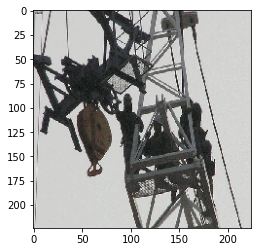

In [13]:
img=preprocess_img(f'{DATASET_PATH_DEFAULT}/10002456.jpg')

plt.imshow(img[0].astype('uint8'))

In [14]:
def encode_img(path):
    img = preprocess_img(path)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [15]:
encode_img_dict = {}
s=0
for current_img in vocab_dict:
    path = f'{DATASET_PATH_DEFAULT}/{current_img}'
    encode_img_dict[current_img] = encode_img(path)
    s+=1
    
    if s % 100 == 0:
        print(s)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [18]:
np.save('encoded_img_dic.npy',encode_img_dict)

In [19]:
!ls -l --b=M  ./encoded_img_dic.npy | cut -d " " -f5

251M


In [20]:
!echo "hello"

hello
